# Homework 7

**Harvard University**<br>
**Fall 2018**<br>
**Instructors: Rahul Dave**<br>
**Due Date: ** Saturday, October 27th, 2018 at 11:59pm

**Instructions:**

- Upload your final answers in the form of a Jupyter notebook containing all work to Canvas.

- Structure your notebook and your work to maximize readability.

### Collaborators

** Place the name of everyone who's submitting this assignment here**

<div class="answer-separator">
------------------------
</div>

In [1]:
import numpy as np
import scipy.stats
import scipy.special

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib import cm
import pandas as pd
%matplotlib inline

## Standard boilerplate to import torch and torch related modules
import torch

import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable

import torch.nn as nn

## Question 1: Mon pays c'est l'MNIST. Mon cœur est brise de Logistic Regression.

The [*MNIST* dataset](https://en.wikipedia.org/wiki/MNIST_database) is one of the classic datasets in Machine Learning and is often one of the first datasets against which new classification algorithms test themselves.  It consists of 70,000 images of handwritten digits, each of which is 28x28 pixels. You will be using PyTorch to build a handwritten digit classifier that you will train, validate, and test with MNIST. 

Your classifier MUST implement a multinomial logistic regression model (using softmax). It will take as input an array of pixel values in an image and output the images most likely digit label (i.e. 0-9). You should think of the pixel values as features of the input vector.  

Using the softmax formulation, your PyTorch model should computes the cost function using an L2 regularization approach (see `optim.SGD` in PyTorch or write your own cost function) and minimize the resulting cost function using mini-batch stochastic gradient descent.  We provided  extensive template code in lab.

Construct and train your classifier using a batch size of 256 examples, a learning rate $\eta$=0.1, and a regularization factor $\lambda$=0.01.

1.1. Plot 10 sample images from the MNIST dataset (to develop intuition for the feature space).

In [2]:
train_dataset = datasets.MNIST(root='./data', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)

test_dataset = datasets.MNIST(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())

In [3]:
train_dataset.train_data.shape

torch.Size([60000, 28, 28])

In [4]:
test_dataset.test_data.shape

torch.Size([10000, 28, 28])

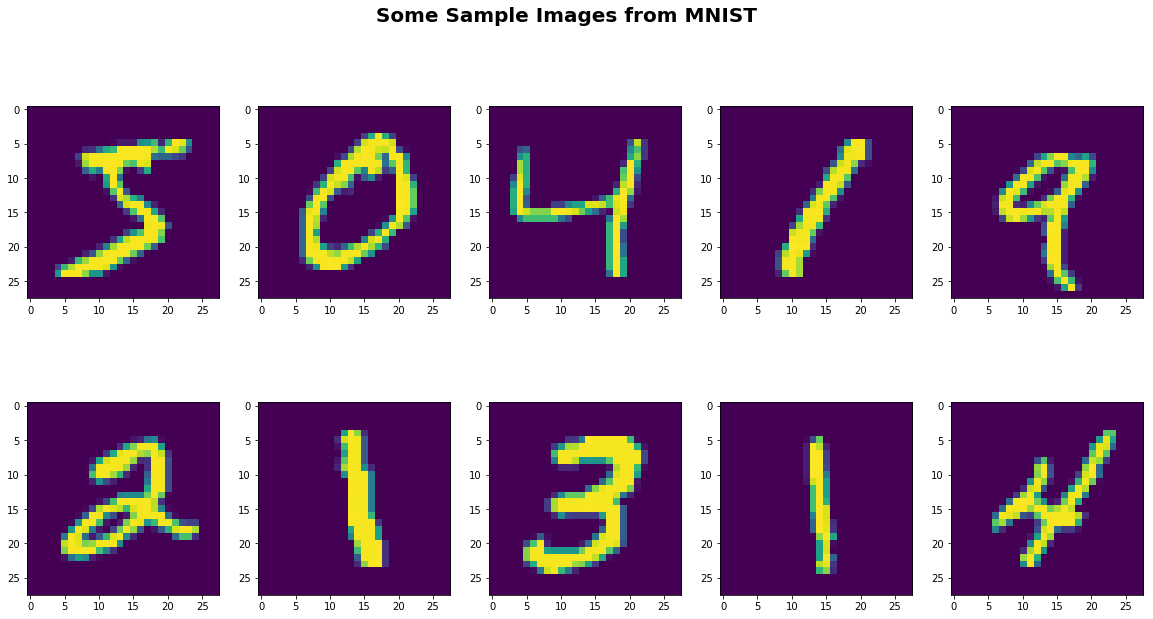

In [5]:
image_samples = train_dataset.train_data[:10]
fig, (ax1, ax2) = plt.subplots(2, 5, figsize=(20, 10))
plt.suptitle("Some Sample Images from MNIST", fontsize=20, weight='heavy')

for i in range(5):
    ax1[i].imshow(image_samples[i])
    ax2[i].imshow(image_samples[i+5])

plt.show()    

1.2. Currently the MNIST dataset in Torchvision allows a Train/Test split.  Use PyTorch dataloader functionality to create a Train/Validate/Test split  of 50K/10K/10K samples.

**Hint:** Lab described a way to do it keeping within the MNIST `DataLoader` workflow: the key is to pass a `SubsetRandomSampler` to `DataLoader`

In [6]:
num_train = len(train_dataset)
indices = list(range(num_train))
split = 10000

validation_idx = np.random.choice(indices, size=split, replace=False)
train_idx = list(set(indices) - set(validation_idx))

train_sampler = SubsetRandomSampler(train_idx)
validation_sampler = SubsetRandomSampler(validation_idx)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, sampler=train_sampler)

validation_loader = torch.utils.data.DataLoader(train_dataset, sampler=validation_sampler)

test_loader = torch.utils.data.DataLoader(test_dataset)

1.3. Construct a softmax formulation in PyTorch of multinomial logistic regression with Cross Entropy Loss.

In [13]:
class LogisticRegressionMNIST(nn.Module):
    def __init__(self, dim_input_size, num_classes, batch_size):
        super().__init__()
        self.l1 = nn.Linear(dim_input_size, num_classes)
        self.training_data_loader, self.validation_data_loader = self.init_data_loader(batch_size)
        self.losses = []
        self.val_acc = []
        
    def init_data_loader(self, bs):
        train_dataset = datasets.MNIST(root='./data', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)
        ## define our indices -- our dataset has 60 000 elements and we want a 50 000:10 000 split
        num_train = len(train_dataset)
        indices = list(range(num_train))
        split = 10000
        
        #set validation and training indices
        validation_idx = np.random.choice(indices, size=split, replace=False)
        train_idx = list(set(indices) - set(validation_idx))
        
        # initialize data loaders
        train_sampler = SubsetRandomSampler(train_idx)
        validation_sampler = SubsetRandomSampler(validation_idx)
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=bs, sampler=train_sampler)
        validation_loader = torch.utils.data.DataLoader(train_dataset, batch_size = split, sampler=validation_sampler)  
        return train_loader, validation_loader
        
    def forward(self, x):
        x = self.l1(x)
        return x
    
    def train(self, epochs = 20, learn_rate = 0.1, reg_param = 0):
        criterion = nn.CrossEntropyLoss()  
        optimizer = torch.optim.SGD(self.parameters(), lr = learn_rate, weight_decay = reg_param)  
        num_epochs = epochs
        self.losses = []
        for epoch in range(num_epochs):
            for batch_idx, (images, labels) in enumerate(self.training_data_loader):
                images = Variable(images.view(-1, 28*28))
                labels = Variable(labels)
                # Forward + Backward + Optimize
                optimizer.zero_grad()
                outputs = self(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                self.losses.append(loss.data.item())
            print('Epoch: [{}/{}], Loss:{}'.format(epoch+1, num_epochs, loss.data.item()))   
            self.val_acc.append(self.validate())
            
    def validate(self):
        correct = 0
        for batch_idx, (images, labels) in enumerate(self.validation_data_loader):
            inputs = Variable(images)
            ## Reshape so that batches work properly
            inputs = inputs.view(-1, 28*28)
            # run our model on the inputs
            outputs = self(inputs)
            # get the class of the max log-probability
            pred = outputs.data.max(1)[1]
            correct += (pred == labels).sum()
        # append current batch of predictions to our list
        acc = correct.item()/10000
        return acc
        

1.4. Train your model using SGD to minimize the cost function. Use as many epochs as you need to achive convergence.

In [18]:
# Training the Model
model_logistic = LogisticRegressionMNIST(784, 10, 64)
model_logistic.train(epochs = 10)

Epoch: [1/10], Loss:0.6681759357452393
Epoch: [2/10], Loss:0.17285974323749542
Epoch: [3/10], Loss:0.09229226410388947
Epoch: [4/10], Loss:0.06273302435874939
Epoch: [5/10], Loss:0.31327083706855774
Epoch: [6/10], Loss:0.2319698929786682
Epoch: [7/10], Loss:0.1527099311351776
Epoch: [8/10], Loss:0.258588969707489
Epoch: [9/10], Loss:0.08751419186592102
Epoch: [10/10], Loss:0.22478657960891724


1.5. Plot the cross-entropy loss on the training set as a function of iteration.

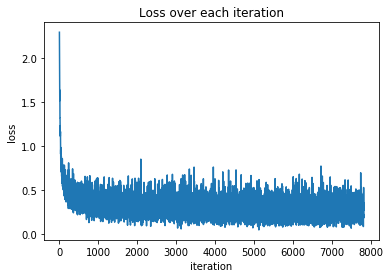

In [21]:
iterations = np.arange(len(model_logistic.losses))
plt.plot(iterations, model_logistic.losses)
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('Loss over each iteration')
plt.show()

1.6. Using classification accuracy, evaluate how well your model is performing on the validation set at the end of each epoch. Plot this validation accuracy as the model trains.

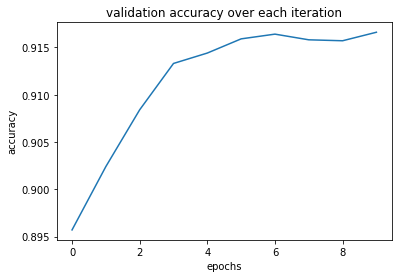

In [22]:
epochs = np.arange(len(model_logistic.val_acc))
plt.plot(epochs, model_logistic.val_acc)
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('validation accuracy over each iteration')
plt.show()

1.6. Duplicate this plot for some other values of the regularization parameter $\lambda$. When should you stop the training for each of the different values of λ? Give an approximate answer supported by using the plots.

In [23]:
reg_params = [0,0.01,0.1,0.5,1]
logistic_models = [LogisticRegressionMNIST(784, 10, 64) for _ in range(len(reg_params))]

In [26]:
for idx, model in enumerate(logistic_models):
    model.train(epochs=10, reg_param = reg_params[idx])

Epoch: [1/10], Loss:0.11978842318058014
Epoch: [2/10], Loss:0.2254224717617035
Epoch: [3/10], Loss:0.22772744297981262
Epoch: [4/10], Loss:0.38291969895362854
Epoch: [5/10], Loss:0.17407138645648956
Epoch: [6/10], Loss:0.10385146737098694
Epoch: [7/10], Loss:0.09129524230957031
Epoch: [8/10], Loss:0.5419981479644775
Epoch: [9/10], Loss:0.8145754337310791
Epoch: [10/10], Loss:0.28951171040534973
Epoch: [1/10], Loss:0.37669309973716736
Epoch: [2/10], Loss:0.251949667930603
Epoch: [3/10], Loss:0.08658123016357422
Epoch: [4/10], Loss:0.5857131481170654
Epoch: [5/10], Loss:0.29290154576301575
Epoch: [6/10], Loss:0.355164110660553
Epoch: [7/10], Loss:0.32077357172966003
Epoch: [8/10], Loss:0.4060593545436859
Epoch: [9/10], Loss:0.5960273742675781
Epoch: [10/10], Loss:0.6954885721206665
Epoch: [1/10], Loss:0.7413889765739441
Epoch: [2/10], Loss:0.8536251187324524
Epoch: [3/10], Loss:0.700790524482727
Epoch: [4/10], Loss:0.7266038656234741
Epoch: [5/10], Loss:1.0076298713684082
Epoch: [6/10], 

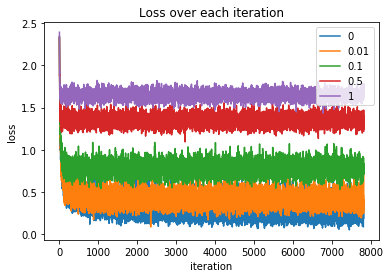

In [34]:
for idx, model in enumerate(logistic_models):
    iterations = np.arange(len(model.losses))
    plt.plot(iterations, model.losses, label = reg_params[idx])
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('Loss over each iteration')
plt.legend()
plt.show()

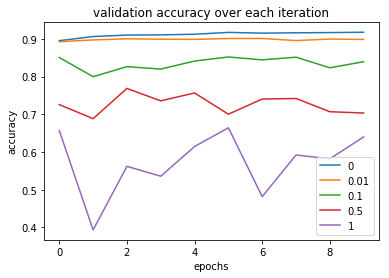

In [32]:
for idx, model in enumerate(logistic_models):
    epochs = np.arange(len(model_logistic.val_acc))
    plt.plot(epochs, model.val_acc, label = str(reg_params[idx]))
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('validation accuracy over each iteration')
plt.legend(loc = 4)
plt.show()

The best regularization parameter seems to be $\lambda = 0$. It appears that the regularization parameter doesn't change the optimal time to stop training - rather, it increases the variance in the validation accuracy, which makes it more challenging to determine the optimal stopping time.

1.7. Select what you consider the best regularization parameter and predict the labels of the test set. Compare your predictions with the given labels. What classification accuracy do you obtain on the training and test sets?

In [46]:
test_dataset

Dataset MNIST
    Number of datapoints: 10000
    Split: test
    Root Location: ./data
    Transforms (if any): ToTensor()
    Target Transforms (if any): None

In [81]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10000)

correct = 0
for batch_idx, (images, labels) in enumerate(test_loader):
    inputs = Variable(images)
    ## Reshape so that batches work properly
    inputs = inputs.view(-1, 28*28)
    # run our model on the inputs
    outputs = logistic_models[0](inputs)
    # get the class of the max log-probability
    pred = outputs.data.max(1)[1]
    correct += (pred == labels).sum()
# append current batch of predictions to our list
acc = correct.item()/10000
print("accuracy on the test set:", acc)

accuracy on the test set: 0.921


1.8. What classes are most likely to be misclassified? Plot some misclassified training and test set images.

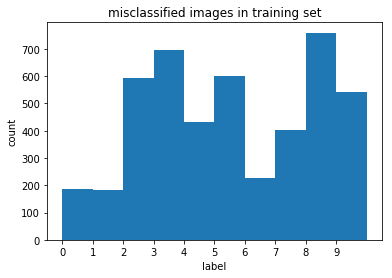

In [90]:
# train set misclassication
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=60000)

correct = 0
for batch_idx, (images, labels) in enumerate(train_loader):
    inputs = Variable(images)
    ## Reshape so that batches work properly
    inputs = inputs.view(-1, 28*28)
    # run our model on the inputs
    outputs = logistic_models[0](inputs)
    # get the class of the max log-probability
    pred_train = outputs.data.max(1)[1]

misclassified_indices_train = [idx for idx, correct in enumerate(pred_train == labels) if not correct]
plt.hist(labels[misclassified_indices_train], bins = list(range(11)))
plt.xticks(range(10))
plt.title('misclassified images in training set')
plt.xlabel('label')
plt.ylabel('count')
plt.show()

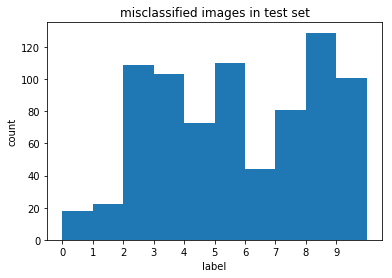

In [91]:
# test set misclassication
correct = 0
for batch_idx, (images, labels) in enumerate(test_loader):
    inputs = Variable(images)
    ## Reshape so that batches work properly
    inputs = inputs.view(-1, 28*28)
    # run our model on the inputs
    outputs = logistic_models[0](inputs)
    # get the class of the max log-probability
    pred_test = outputs.data.max(1)[1]

misclassified_indices_test = [idx for idx, correct in enumerate(pred_test == labels) if not correct]
plt.hist(labels[misclassified_indices_test], bins = list(range(11)))
plt.xticks(range(10))
plt.title('misclassified images in test set')
plt.xlabel('label')
plt.ylabel('count')
plt.show()

The most common number to be misclassified in the training and test sets are 2, 3, 5,and 8.

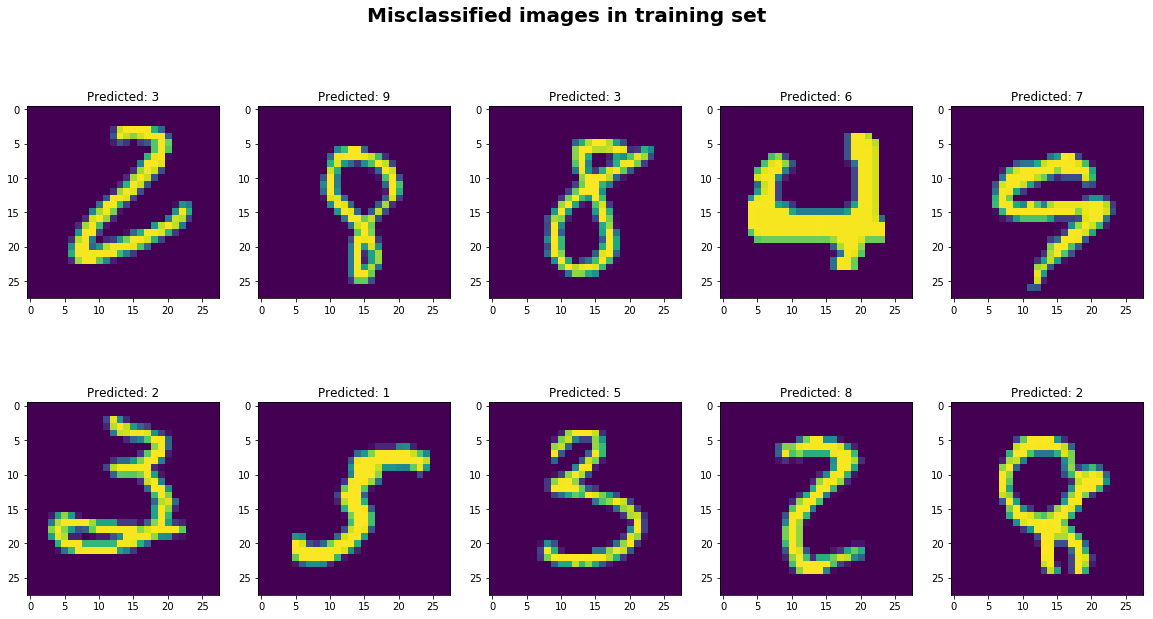

In [104]:
idx_samples = np.random.choice(misclassified_indices_train, 10)
image_samples = train_dataset.train_data[idx_samples]
pred_train_samples = pred_train[idx_samples]
fig, (ax1, ax2) = plt.subplots(2, 5, figsize=(20, 10))
plt.suptitle("Misclassified images in training set", fontsize=20, weight='heavy')

for i in range(5):
    ax1[i].imshow(image_samples[i])
    ax1[i].set_title('Predicted: {}'.format(pred_train_samples[i].item()))
    ax2[i].imshow(image_samples[i+5])
    ax2[i].set_title('Predicted: {}'.format(pred_train_samples[i+5].item()))
plt.show()    

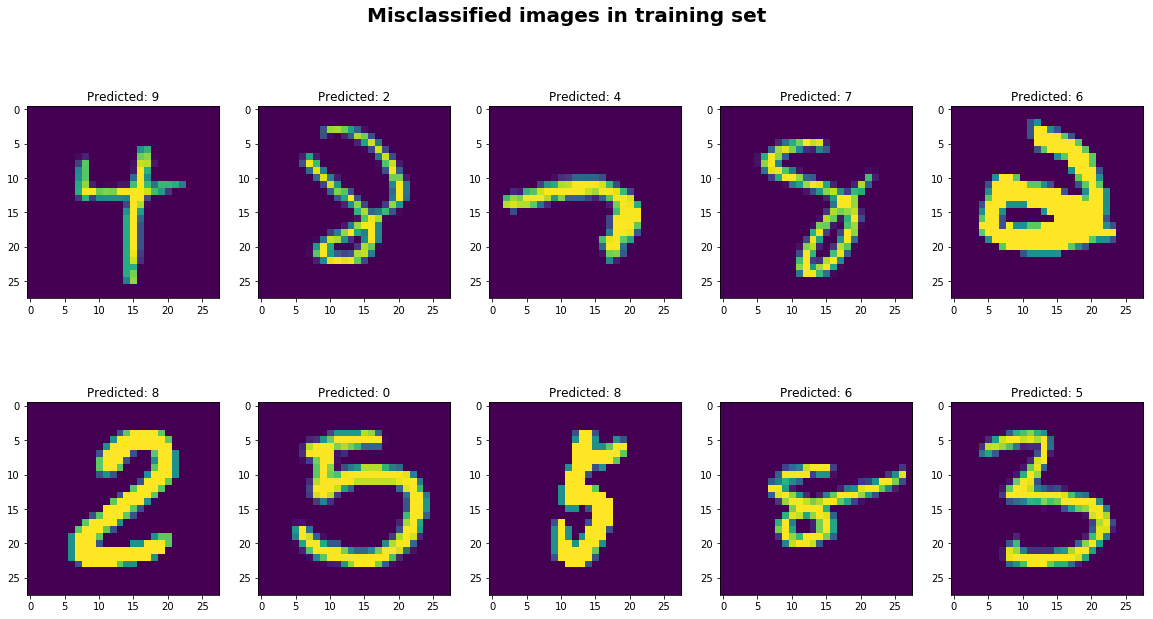

In [105]:
idx_samples = np.random.choice(misclassified_indices_test, 10)
image_samples = test_dataset.test_data[idx_samples]
pred_test_samples = pred_test[idx_samples]
fig, (ax1, ax2) = plt.subplots(2, 5, figsize=(20, 10))
plt.suptitle("Misclassified images in training set", fontsize=20, weight='heavy')

for i in range(5):
    ax1[i].imshow(image_samples[i])
    ax1[i].set_title('Predicted: {}'.format(pred_test_samples[i].item()))
    ax2[i].imshow(image_samples[i+5])
    ax2[i].set_title('Predicted: {}'.format(pred_test_samples[i+5].item()))
plt.show()    

**Gratuitous Titular Reference**:  The recently departed French rockstar Johnny Hallyday just posthumously released what looks to be his biggest album ever "Mon pays c'est l'amour".  The album sold 300,000 copies on its first day of release.

<div class="answer-separator">
------------------------
</div>

## Question 2: MNIST MLP!  Find out what that means to me.  MNIST MLP!  Take care, TCB!

The multilayer perceptron can be understood as a logistic regression classifier in which the input is first transformed using a learnt non-linear transformation. The non-linear transformation is often chosen to be either the logistic function or the $\tanh$ function or the RELU function, and its purpose is to project the data into a space where it becomes linearly separable. The output of this so-called hidden layer is then passed to the logistic regression graph that we have constructed in the first problem. 

![](http://deeplearning.net/tutorial/_images/mlp.png)

We'll construct a model with **1 hidden layer**. That is, you will have an input layer, then a hidden layer with the nonlinearity, and finally an output layer with cross-entropy loss (or equivalently log-softmax activation with a negative log likelihood loss).

2.1. Using a similar architecture as in Question 1 and the same training, validation and test sets, build a PyTorch model for the multilayer perceptron. Use the $\tanh$ function as the non-linear activation function. 

In [107]:
len(validation_loader.dataset)

60000

In [108]:
class MLP_MNIST(nn.Module):
    def __init__(self, dim_input_size, dim_hidden, num_classes, batch_size):
        super().__init__()
        self.l1 = nn.Linear(dim_input_size, dim_hidden)
        self.a1 = nn.Tanh()
        self.l2 = nn.Linear(dim_hidden, num_classes)
        nn.init.xavier_uniform_(self.l2.weight)
        self.training_data_loader, self.validation_data_loader = self.init_data_loader(batch_size)
        self.losses = []
        self.val_acc = []
        
    def init_data_loader(self, bs):
        train_dataset = datasets.MNIST(root='./data', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)
        ## define our indices -- our dataset has 9 elements and we want a 8:4 split
        num_train = len(train_dataset)
        indices = list(range(num_train))
        split = 10000

        validation_idx = np.random.choice(indices, size=split, replace=False)
        train_idx = list(set(indices) - set(validation_idx))

        train_sampler = SubsetRandomSampler(train_idx)
        validation_sampler = SubsetRandomSampler(validation_idx)

        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=bs, sampler=train_sampler)

        validation_loader = torch.utils.data.DataLoader(train_dataset, batch_size = split, sampler=validation_sampler)
        
        return train_loader, validation_loader
        
    def forward(self, x):
        x = self.l1(x)
        x = self.a1(x)
        x = self.l2(x)
        return x
    
    def train(self, epochs = 20, learn_rate = 0.01, reg_param = 0.01):
        criterion = nn.CrossEntropyLoss()  
        optimizer = torch.optim.SGD(self.parameters(), lr = learn_rate, weight_decay = reg_param)  
        num_epochs = epochs
        self.losses = []
        for epoch in range(num_epochs):
            for batch_idx, (images, labels) in enumerate(self.training_data_loader):
                images = Variable(images.view(-1, 28*28))
                labels = Variable(labels)
                # Forward + Backward + Optimize
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                self.losses.append(loss.data.item())
            print('Epoch: [{}/{}], Loss:{}'.format(epoch+1, num_epochs, loss.data.item()))   
            self.val_acc.append(self.validate())
            
    def validate(self):
        correct = 0
        for batch_idx, (images, labels) in enumerate(self.validation_data_loader):
            inputs = Variable(images)
            ## Reshape so that batches work properly
            inputs = inputs.view(-1, 28*28)
            # run our model on the inputs
            outputs = self(inputs)
            # get the class of the max log-probability
            pred = outputs.data.max(1)[1]
            correct += (pred == labels).sum()
        # append current batch of predictions to our list
        acc = correct.item()/10000
        return acc

2.2. The initialization of the weights matrix for the hidden layer must assure that the units (neurons) of the perceptron operate in a regime where information gets propagated. For the $\tanh$ function, you may find it advisable to initialize with the interval $\left[-\sqrt{\frac{6}{fan_{in}+fan_{out}}},\sqrt{\frac{6}{fan_{in}+fan_{out}}}\right]$, where $fan_{in}$ is the number of units in the $(i-1)$-th layer, and $fan_{out}$ is the number of units in the i-th layer.  This is known as **Xavier Initialization**.  Use Xavier Initialization to initialize your MLP.  Feel free to use PyTorch's in-built Xavier Initialization methods.

_implemented above_

2.3. Using $\lambda = 0.01$ to compare with Question 1, experiment with the learning rate (try 0.1 and 0.01 for example), batch size (use 64, 128 and 256) and the number of units in your hidden layer (use between 25 and 200 units). For what combination of these parameters do you obtain the highest validation accuracy?  You may want to start with 20 epochs for running time and experiment a bit to make sure that your models reach convergence. 

In [109]:
learning_rates = [0.1,0.01]
batch_size = [64,128,256]
hidden_units = [25,200]

best_val = 0
best_lr = None
best_batch_size = None
best_hidden_unit = None
for lr in learning_rates:
    for bs in batch_size:
        for hu in hidden_units:
            print('-----------------------------')
            print(lr,bs, hu)
            model = MLP_MNIST(784,hu,10,bs)
            model.train(learn_rate = lr)
            acc = model.validate()
            if acc > best_val:
                best_val = acc
                best_lr = lr
                best_batch_size = bs
                best_hidden_unit = hu

-----------------------------
0.1 64 25
Epoch: [1/20], Loss:0.2818602919578552
Epoch: [2/20], Loss:0.2955929636955261
Epoch: [3/20], Loss:0.415109246969223
Epoch: [4/20], Loss:0.25389552116394043
Epoch: [5/20], Loss:0.6802638173103333
Epoch: [6/20], Loss:0.28392016887664795
Epoch: [7/20], Loss:0.14055229723453522
Epoch: [8/20], Loss:0.4646081030368805
Epoch: [9/20], Loss:0.23643243312835693
Epoch: [10/20], Loss:0.29727476835250854
Epoch: [11/20], Loss:0.16942623257637024
Epoch: [12/20], Loss:0.43772202730178833
Epoch: [13/20], Loss:0.5048222541809082
Epoch: [14/20], Loss:0.3370732069015503
Epoch: [15/20], Loss:0.8135120868682861
Epoch: [16/20], Loss:0.5436864495277405
Epoch: [17/20], Loss:0.2792244553565979
Epoch: [18/20], Loss:0.501766562461853
Epoch: [19/20], Loss:0.15332576632499695
Epoch: [20/20], Loss:0.18011771142482758
-----------------------------
0.1 64 200
Epoch: [1/20], Loss:0.3219914436340332
Epoch: [2/20], Loss:0.6755320429801941
Epoch: [3/20], Loss:0.5666255354881287
Epoc

Epoch: [17/20], Loss:0.30772170424461365
Epoch: [18/20], Loss:0.3553854525089264
Epoch: [19/20], Loss:0.3770736753940582
Epoch: [20/20], Loss:0.297259658575058
-----------------------------
0.01 256 25
Epoch: [1/20], Loss:1.1550114154815674
Epoch: [2/20], Loss:0.8835442662239075
Epoch: [3/20], Loss:0.6836565136909485
Epoch: [4/20], Loss:0.7013660669326782
Epoch: [5/20], Loss:0.6473225355148315
Epoch: [6/20], Loss:0.5944092869758606
Epoch: [7/20], Loss:0.5548415780067444
Epoch: [8/20], Loss:0.5008860230445862
Epoch: [9/20], Loss:0.5164755582809448
Epoch: [10/20], Loss:0.506812334060669
Epoch: [11/20], Loss:0.5167309641838074
Epoch: [12/20], Loss:0.3882996439933777
Epoch: [13/20], Loss:0.4340609610080719
Epoch: [14/20], Loss:0.3807658553123474
Epoch: [15/20], Loss:0.6314939260482788
Epoch: [16/20], Loss:0.42304497957229614
Epoch: [17/20], Loss:0.38369518518447876
Epoch: [18/20], Loss:0.4508281350135803
Epoch: [19/20], Loss:0.41306108236312866
Epoch: [20/20], Loss:0.43172675371170044
----

In [110]:
print('best learning rate:', best_lr)
print('best batch size:', best_batch_size)
print('best hidden unit dimension', best_hidden_unit)

best learning rate: 0.1
best batch size: 128
best hidden unit dimension 25


2.4. For your best combination plot the cross-entropy loss on the training set as a function of iteration.

In [111]:
model = MLP_MNIST(784,best_hidden_unit,10,best_batch_size)
model.train(learn_rate = best_lr)

Epoch: [1/20], Loss:0.41652947664260864
Epoch: [2/20], Loss:0.3541351556777954
Epoch: [3/20], Loss:0.27895835041999817
Epoch: [4/20], Loss:0.2948111295700073
Epoch: [5/20], Loss:0.24590930342674255
Epoch: [6/20], Loss:0.3710329234600067
Epoch: [7/20], Loss:0.2584454417228699
Epoch: [8/20], Loss:0.480614572763443
Epoch: [9/20], Loss:0.3044705390930176
Epoch: [10/20], Loss:0.3939027786254883
Epoch: [11/20], Loss:0.37535014748573303
Epoch: [12/20], Loss:0.4190761148929596
Epoch: [13/20], Loss:0.25021737813949585
Epoch: [14/20], Loss:0.29616469144821167
Epoch: [15/20], Loss:0.2747444212436676
Epoch: [16/20], Loss:0.3033629357814789
Epoch: [17/20], Loss:0.20547065138816833
Epoch: [18/20], Loss:0.34808701276779175
Epoch: [19/20], Loss:0.4680606424808502
Epoch: [20/20], Loss:0.44905680418014526


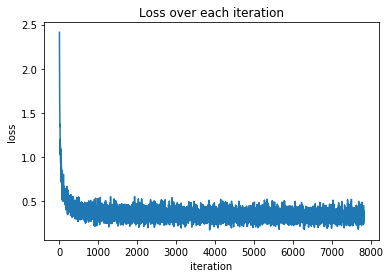

In [112]:
iterations = np.arange(len(model.losses))
plt.plot(iterations, model.losses)
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('Loss over each iteration')
plt.show()

2.5. For your best combination use classification accuracy to evaluate how well your model is performing on the validation set at the end of each epoch. Plot this validation accuracy as the model trains.

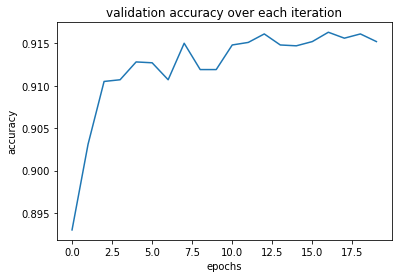

In [113]:
epochs = np.arange(len(model.val_acc))
plt.plot(epochs, model.val_acc)
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('validation accuracy over each iteration')
plt.show()

2.6. Select what you consider the best set of parameters and predict the labels of the test set. Compare your predictions with the given labels. What classification accuracy do you obtain on the training and test sets?

In [130]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10000)

correct = 0
for batch_idx, (images, labels) in enumerate(test_loader):
    inputs = Variable(images)
    ## Reshape so that batches work properly
    inputs = inputs.view(-1, 28*28)
    # run our model on the inputs
    outputs = model(inputs)
    # get the class of the max log-probability
    pred = outputs.data.max(1)[1]
    correct += (pred == labels).sum()
# append current batch of predictions to our list
acc = correct.item()/10000
print("accuracy on the test set:", acc)

accuracy on the test set: 0.9214


2.7. How does your test accuracy compare to that of the logistic regression classifier in Question 1?  Compare best parameters for both models.

The test accuracy is very similar for the MLP and logistic regression. The MLP performs better with more regularization as compared to logistic regression.

2.8. What classes are most likely to be misclassified? Plot some misclassified training and test set images.

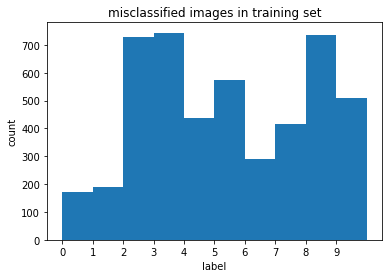

In [132]:
# train set misclassication
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=60000)

correct = 0
for batch_idx, (images, labels) in enumerate(train_loader):
    inputs = Variable(images)
    ## Reshape so that batches work properly
    inputs = inputs.view(-1, 28*28)
    # run our model on the inputs
    outputs = model(inputs)
    # get the class of the max log-probability
    pred_train = outputs.data.max(1)[1]

misclassified_indices_train = [idx for idx, correct in enumerate(pred_train == labels) if not correct]
plt.hist(labels[misclassified_indices_train], bins = list(range(11)))
plt.xticks(range(10))
plt.title('misclassified images in training set')
plt.xlabel('label')
plt.ylabel('count')
plt.show()

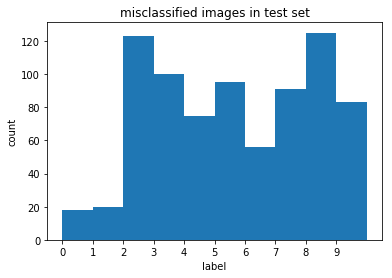

In [133]:
# test set misclassication
correct = 0
for batch_idx, (images, labels) in enumerate(test_loader):
    inputs = Variable(images)
    ## Reshape so that batches work properly
    inputs = inputs.view(-1, 28*28)
    # run our model on the inputs
    outputs = model(inputs)
    # get the class of the max log-probability
    pred_test = outputs.data.max(1)[1]

misclassified_indices_test = [idx for idx, correct in enumerate(pred_test == labels) if not correct]
plt.hist(labels[misclassified_indices_test], bins = list(range(11)))
plt.xticks(range(10))
plt.title('misclassified images in test set')
plt.xlabel('label')
plt.ylabel('count')
plt.show()

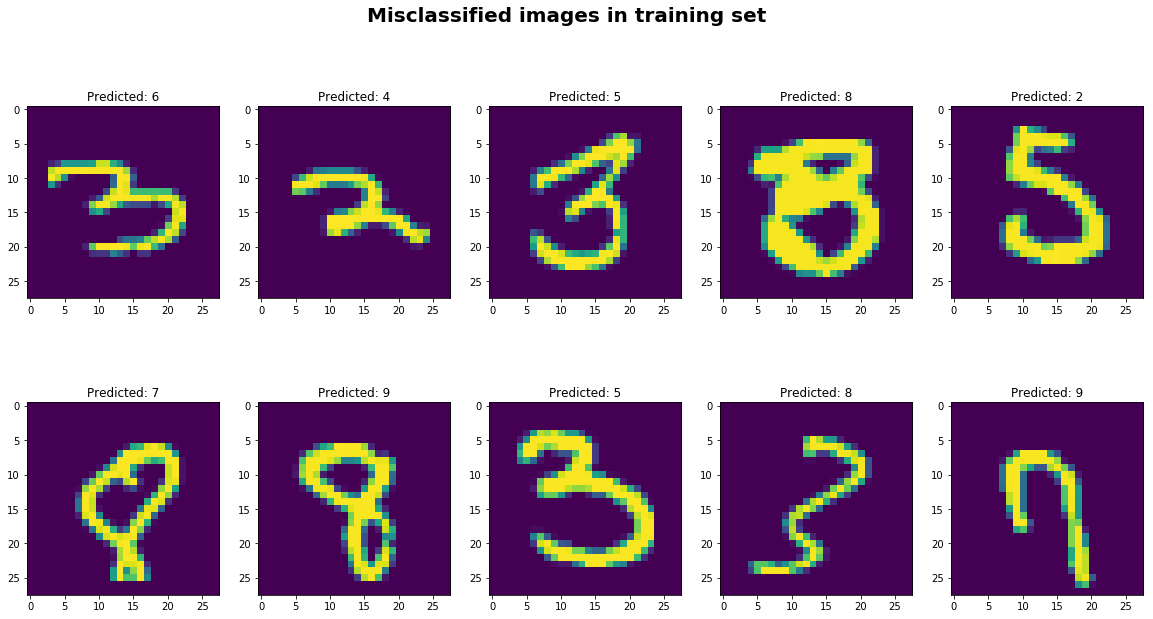

In [134]:
idx_samples = np.random.choice(misclassified_indices_train, 10)
image_samples = train_dataset.train_data[idx_samples]
pred_train_samples = pred_train[idx_samples]
fig, (ax1, ax2) = plt.subplots(2, 5, figsize=(20, 10))
plt.suptitle("Misclassified images in training set", fontsize=20, weight='heavy')

for i in range(5):
    ax1[i].imshow(image_samples[i])
    ax1[i].set_title('Predicted: {}'.format(pred_train_samples[i].item()))
    ax2[i].imshow(image_samples[i+5])
    ax2[i].set_title('Predicted: {}'.format(pred_train_samples[i+5].item()))
plt.show()    

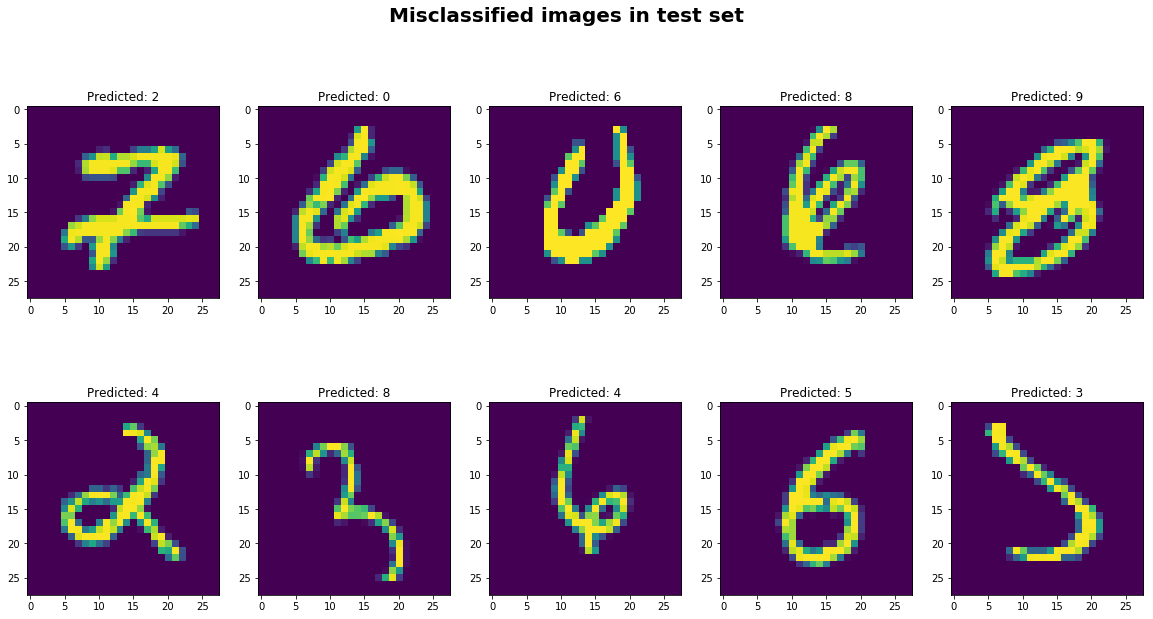

In [136]:
idx_samples = np.random.choice(misclassified_indices_test, 10)
image_samples = test_dataset.test_data[idx_samples]
pred_test_samples = pred_test[idx_samples]
fig, (ax1, ax2) = plt.subplots(2, 5, figsize=(20, 10))
plt.suptitle("Misclassified images in test set", fontsize=20, weight='heavy')

for i in range(5):
    ax1[i].imshow(image_samples[i])
    ax1[i].set_title('Predicted: {}'.format(pred_test_samples[i].item()))
    ax2[i].imshow(image_samples[i+5])
    ax2[i].set_title('Predicted: {}'.format(pred_test_samples[i+5].item()))
plt.show()    

**Gratuitous Titular Reference**:  Respect, originally performed by Otis Redding, became a huge hit and an anthem for the recently departed "Queen of Soul" Aretha Franklin.  Respect is often credited with popularizing the word usages "propers" (a synonym for respect) and "sock it to me".

<div class="answer-separator">
------------------------
</div>